# Requirements

In [1]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

C:\Users\Vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Verify GPU availability
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Version: {torch.version.cuda}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Version: 12.4
Device: cuda


In [3]:
dataset_root = "./dataset/PlantVillage"  # Update with your dataset path
output_dir = "./plantvillage_preprocessed"
os.makedirs(output_dir, exist_ok=True)

# Loading Data

In [4]:
image_paths = []
labels = []
class_names = sorted(os.listdir(dataset_root))
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(dataset_root, class_name)
    if os.path.isdir(class_dir):
        class_images = glob.glob(os.path.join(class_dir, "*.JPG"))
        image_paths.extend(class_images)
        labels.extend([class_name] * len(class_images))

In [5]:
class_counts = Counter(labels)
max_count = max(class_counts.values())
augmentation_factors = {cls: max_count // count for cls, count in class_counts.items()}

In [6]:
# Define augmentation pipeline
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=15, p=0.4, border_mode=cv2.BORDER_REFLECT),
    A.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.8, 1.2), p=1.0),
    A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.6),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.4),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Data Preprocessing and Augmentation

In [7]:
augmented_images = []
augmented_labels = []
output_class_dirs = {name: os.path.join(output_dir, name) for name in class_names}

In [8]:
for class_name in class_names:
    os.makedirs(output_class_dirs[class_name], exist_ok=True)

In [9]:
for img_path, label in zip(image_paths, labels):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Failed to load image {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Save original (resized and normalized)
    img_aug = augment(image=img)['image']
    output_path = os.path.join(output_class_dirs[label], os.path.basename(img_path))
    cv2.imwrite(output_path, cv2.cvtColor((img_aug * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    augmented_images.append(output_path)
    augmented_labels.append(label)
    
    # Augment minority classes
    aug_factor = augmentation_factors[label] - 1
    for i in range(aug_factor):
        aug_img = augment(image=img)['image']
        aug_img_path = os.path.join(output_class_dirs[label], f"aug_{i}_{os.path.basename(img_path)}")
        cv2.imwrite(aug_img_path, cv2.cvtColor((aug_img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
        augmented_images.append(aug_img_path)
        augmented_labels.append(label)

In [10]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    augmented_images, augmented_labels, test_size=0.3, stratify=augmented_labels, random_state=42
)

In [11]:
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.3333, stratify=temp_labels, random_state=42
)

In [12]:
def save_split_metadata(paths, labels, split_name):
    df = pd.DataFrame({"image_path": paths, "label": labels})
    df.to_csv(os.path.join(output_dir, f"{split_name}_split.csv"), index=False)

In [13]:
save_split_metadata(train_paths, train_labels, "train")
save_split_metadata(val_paths, val_labels, "val")
save_split_metadata(test_paths, test_labels, "test")

In [14]:
print(f"Total images: {len(augmented_images)}")
print(f"Train set: {len(train_paths)}")
print(f"Validation set: {len(val_paths)}")
print(f"Test set: {len(test_paths)}")
print(f"Train class distribution: {Counter(train_labels)}")

Total images: 40657
Train set: 28459
Validation set: 8132
Test set: 4066
Train class distribution: Counter({'Tomato__Tomato_YellowLeaf__Curl_Virus': 2245, 'Potato___healthy': 2234, 'Tomato_healthy': 2227, 'Tomato_Early_blight': 2100, 'Potato___Late_blight': 2100, 'Potato___Early_blight': 2100, 'Pepper__bell___Bacterial_spot': 2094, 'Tomato__Tomato_mosaic_virus': 2089, 'Pepper__bell___healthy': 2068, 'Tomato_Leaf_Mold': 1999, 'Tomato__Target_Spot': 1965, 'Tomato_Bacterial_spot': 1489, 'Tomato_Late_blight': 1336, 'Tomato_Septoria_leaf_spot': 1240, 'Tomato_Spider_mites_Two_spotted_spider_mite': 1173})


# Exploratory Data Analysis (EDA)

In [15]:
train_csv = os.path.join(output_dir, "train_split.csv")
train_df = pd.read_csv(train_csv)

In [16]:
def show_montage(df, label, n=9):
    """Display a montage of n sample images for a given label."""
    subset = df[df['label'] == label].sample(n, random_state=42)
    plt.figure(figsize=(8, 8))
    for i, path in enumerate(subset['image_path']):
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: Failed to load image {path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Sample Images: {label}", fontsize=16)
    plt.tight_layout()
    plt.show()

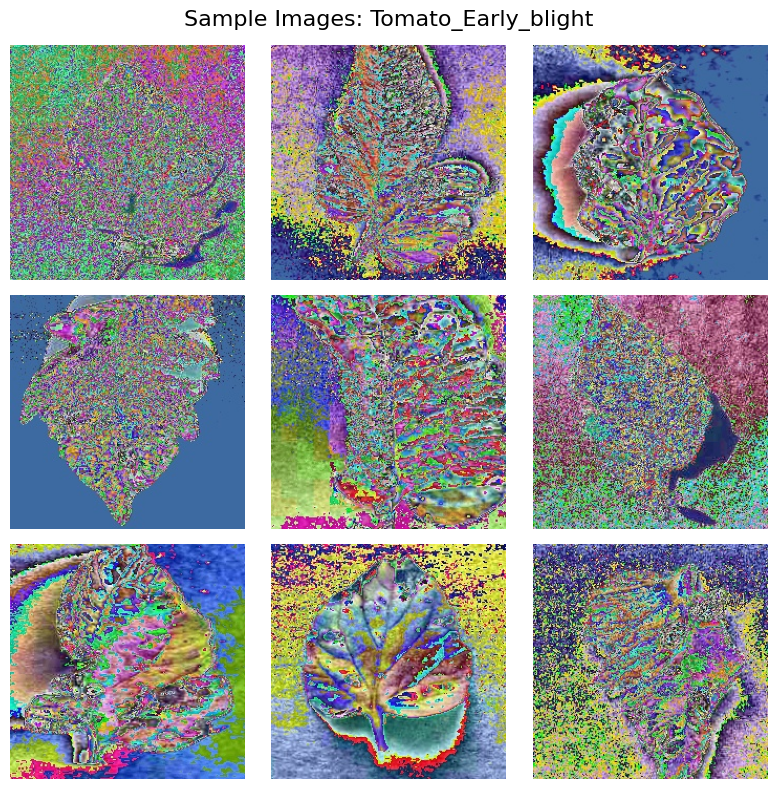

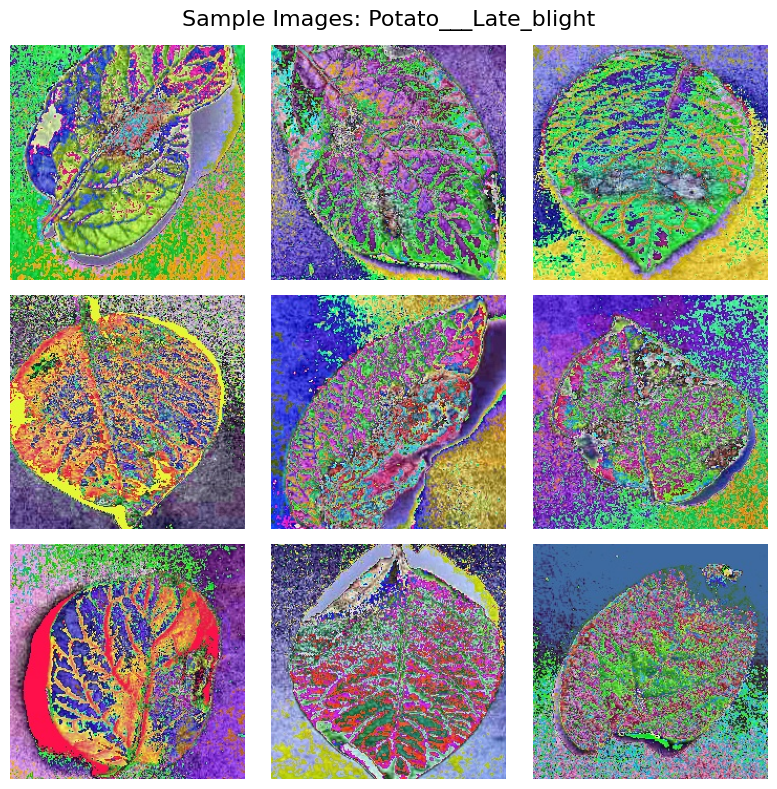

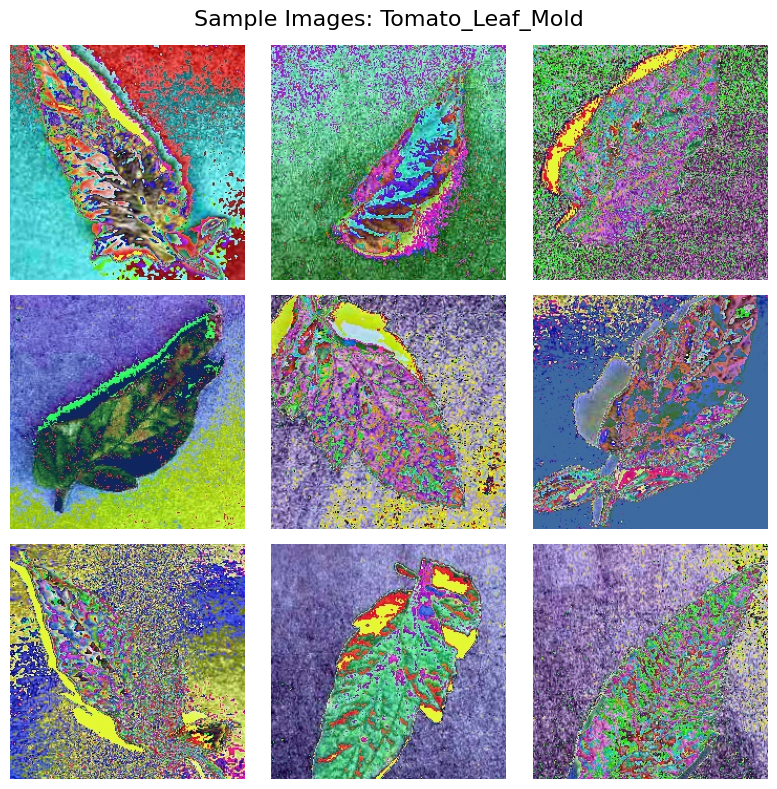

In [17]:
for label in train_df['label'].unique()[:3]:
    show_montage(train_df, label)

In [18]:
def plot_pie_chart(data, title):
    labels = list(data.keys())
    sizes = list(data.values())
    colors = sns.color_palette('tab20', len(labels))
    
    plt.figure(figsize=(12, 8))
    plt.pie(sizes, labels=None, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.table(
        cellText=[[labels[i], sizes[i]] for i in range(len(labels))],
        colLabels=["Class", "Count"],
        loc='upper right',
        cellLoc='left',
        colLoc='center',
        bbox=[1.05, 0.3, 0.4, 0.6]
    )
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

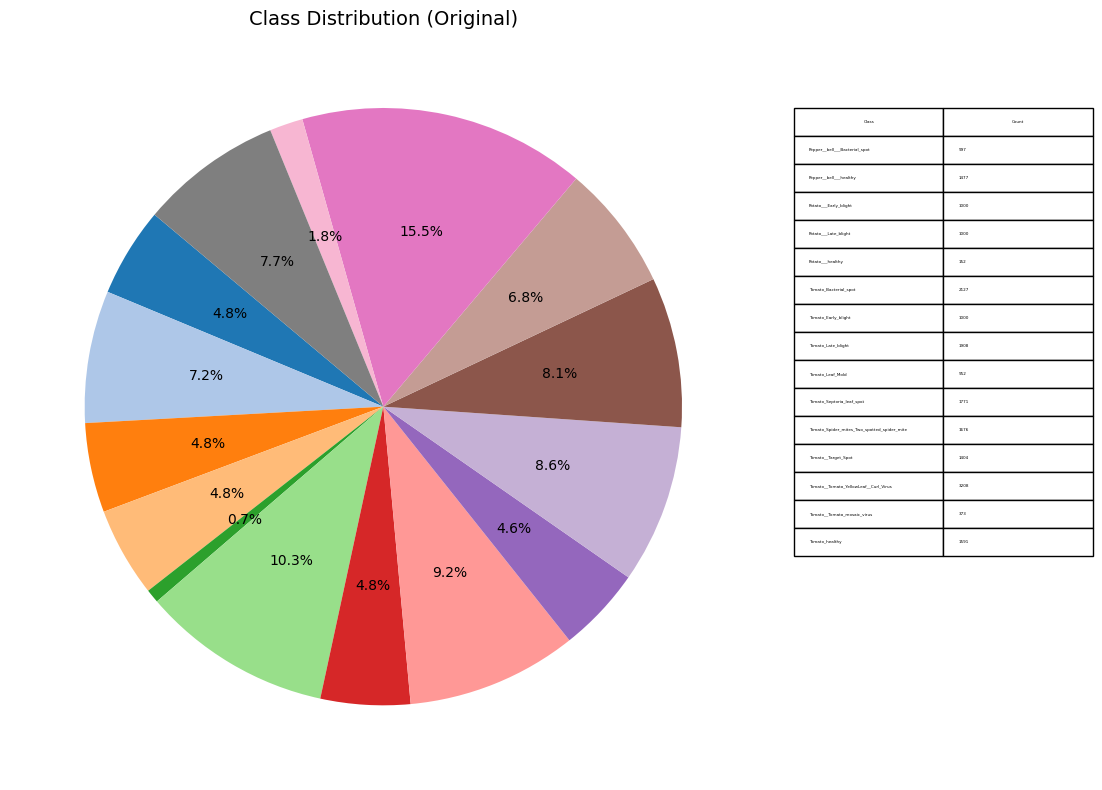

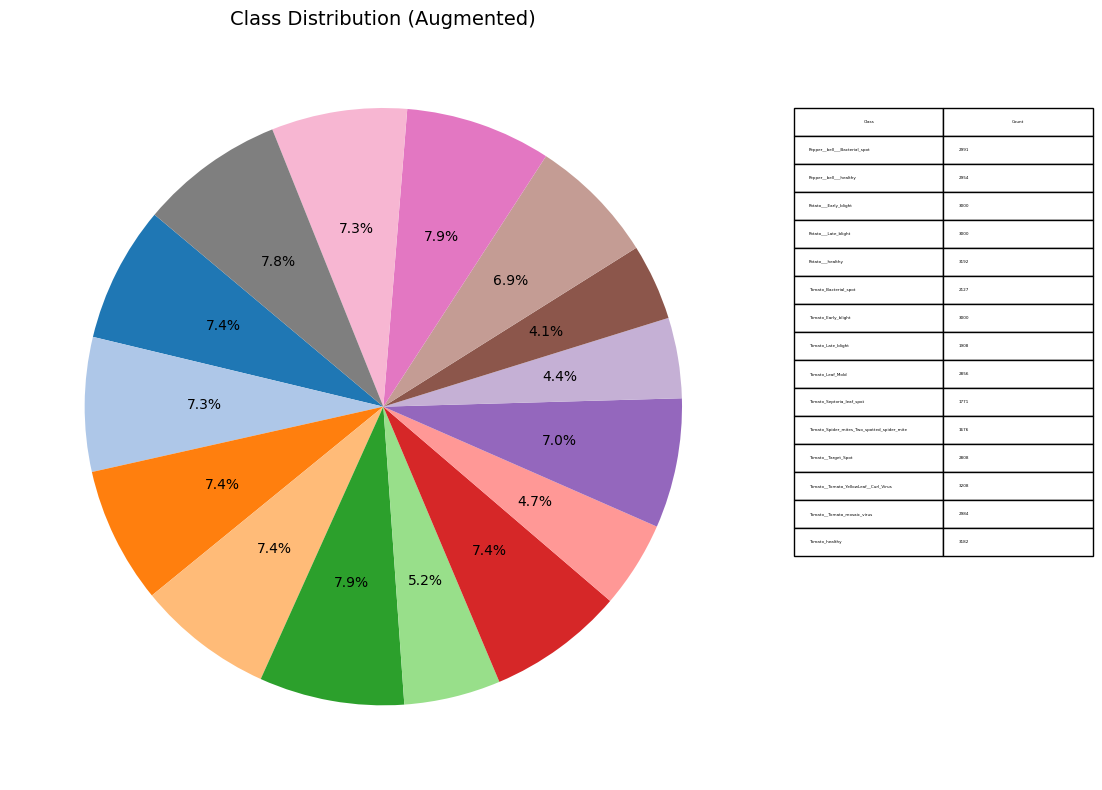

In [19]:
plot_pie_chart(class_counts, "Class Distribution (Original)")
plot_pie_chart(Counter(augmented_labels), "Class Distribution (Augmented)")

In [20]:
train_df['health_status'] = train_df['label'].apply(lambda x: 'Healthy' if 'healthy' in x.lower() else 'Diseased')
status_counts = train_df['health_status'].value_counts()

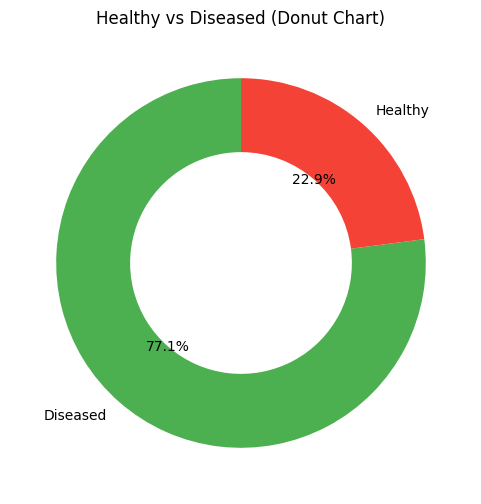

In [21]:
plt.figure(figsize=(6, 6))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#F44336'], wedgeprops={'width': 0.4})
plt.title("Healthy vs Diseased (Donut Chart)")
plt.show()

## Feature Extraction for PCA/t-SNE

In [22]:
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove final layer
model.eval()
model = model.to(device)

C:\Users\Vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [24]:
def extract_features(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(image).squeeze().cpu().numpy()
    return features

In [25]:
features_list = [extract_features(path) for path in image_paths]
X = np.array([f.flatten() for f in features_list])
labels_indices = [class_to_idx[label] for label in labels]

## PCA

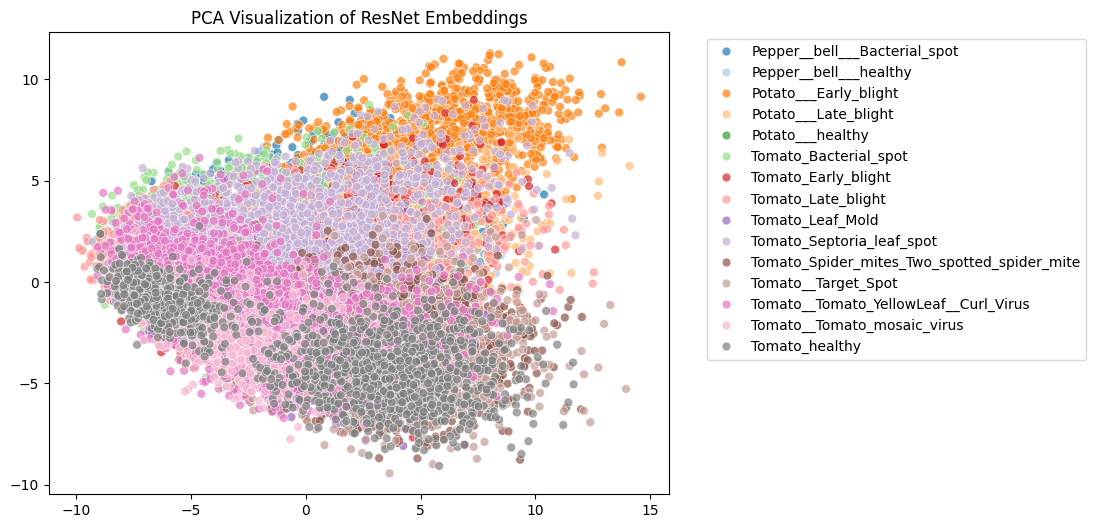

In [26]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="tab20", s=40, alpha=0.7)
plt.title("PCA Visualization of ResNet Embeddings")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## t-SNE

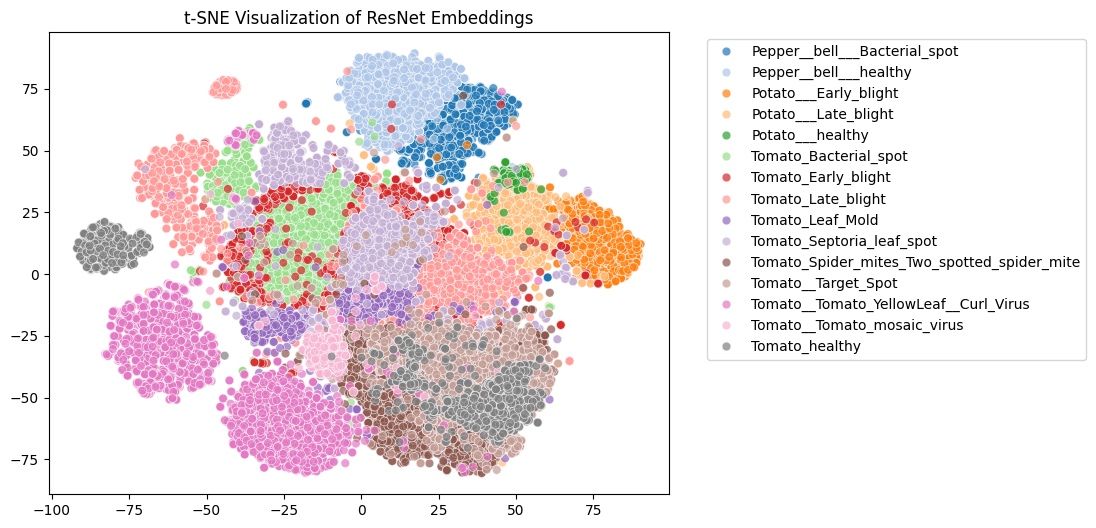

In [27]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette="tab20", s=40, alpha=0.7)
plt.title("t-SNE Visualization of ResNet Embeddings")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Statistics

## Chi-Square Test for Class Distribution

In [28]:
class_counts = train_df['label'].value_counts()
observed = np.array(list(class_counts))
expected = np.full_like(observed, sum(observed) / len(observed))

In [29]:
diff = sum(observed) - sum(expected)
for i in range(int(diff)):
    expected[i] += 1

print(observed, "|", expected)

[2245 2234 2227 2100 2100 2100 2094 2089 2068 1999 1965 1489 1336 1240
 1173] | [1898 1898 1898 1898 1897 1897 1897 1897 1897 1897 1897 1897 1897 1897
 1897]


In [30]:
chi_stat, p_value = chisquare(observed, expected)
print(f"Chi-Square Statistic: {chi_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print("Reject null hypothesis: Class distribution is not uniform." if p_value < 0.05 else 
      "Fail to reject null hypothesis: Class distribution is uniform.")

Chi-Square Statistic: 1065.6397
P-value: 0.0000
Reject null hypothesis: Class distribution is not uniform.


## ANOVA Test

def extract_rgb_intensities(df):
    r_groups, g_groups, b_groups = [], [], []
    for label in df['label'].unique():
        class_paths = df[df['label'] == label]['image_path'].tolist()
        if len(class_paths) < 2:  # Skip classes with insufficient samples
            print(f"Skipping {label}: Only {len(class_paths)} sample(s)")
            continue
        r_intensities, g_intensities, b_intensities = [], [], []
        for path in class_paths:
            img = cv2.imread(path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            r_intensities.extend(img[:, :, 0].flatten())
            g_intensities.extend(img[:, :, 1].flatten())
            b_intensities.extend(img[:, :, 2].flatten())
        r_groups.append(r_intensities)
        g_groups.append(g_intensities)
        b_groups.append(b_intensities)
    return r_groups, g_groups, b_groups

r_groups, g_groups, b_groups = extract_rgb_intensities(train_df)
if r_groups and g_groups and b_groups:  # Ensure groups are not empty
    r_stat, r_p = f_oneway(*r_groups) if len(r_groups) > 1 else (np.nan, np.nan)
    g_stat, g_p = f_oneway(*g_groups) if len(g_groups) > 1 else (np.nan, np.nan)
    b_stat, b_p = f_oneway(*b_groups) if len(b_groups) > 1 else (np.nan, np.nan)
    print(f"ANOVA Red Channel: Statistic={r_stat:.4f}, P-value={r_p:.4f}")
    print(f"ANOVA Green Channel: Statistic={g_stat:.4f}, P-value={g_p:.4f}")
    print(f"ANOVA Blue Channel: Statistic={b_stat:.4f}, P-value={b_p:.4f}")
else:
    print("ANOVA skipped: Insufficient valid groups for analysis.")

for channel, p in [("Red", r_p), ("Green", g_p), ("Blue", b_p)]:
    if p < 0.05:
        print(f"{channel} Channel: Significant differences across classes.")
    else:
        print(f"{channel} Channel: No significant differences across classes.")

# Model Training

In [31]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [32]:
data_dir = "./plantvillage_preprocessed"
train_csv = os.path.join(data_dir, "train_split.csv")
val_csv = os.path.join(data_dir, "val_split.csv")
test_csv = os.path.join(data_dir, "test_split.csv")

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [34]:
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset 

In [35]:
class PlantVillageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.classes = sorted(self.data['label'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.labels = [self.class_to_idx[label] for label in self.data['label']]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

    def num_classes(self):
        return len(self.classes)

In [36]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [37]:
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [38]:
train_dataset = PlantVillageDataset(train_csv, transform=train_transform)
val_dataset = PlantVillageDataset(val_csv, transform=val_test_transform)
test_dataset = PlantVillageDataset(test_csv, transform=val_test_transform)

In [39]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [40]:
num_classes = train_dataset.num_classes()  # 15 classes from notebook
model = models.resnet50(weights='IMAGENET1K_V2')

In [41]:
for param in model.parameters():
    param.requires_grad = False

In [42]:
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [43]:
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

In [44]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset  # Added Dataset import
from torchvision import models, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import copy

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

In [46]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0

In [47]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct.double() / total
    return epoch_loss, epoch_acc.item()

In [48]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    val_loss = running_loss / total
    val_acc = correct.double() / total
    return val_loss, val_acc.item()

In [49]:
num_epochs = 50
early_stopping = EarlyStopping(patience=5, delta=0.001)
best_val_acc = 0.0
best_model_wts = None

In [50]:
model = model.to(device)

In [ ]:
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, os.path.join(data_dir, "best_resnet50.pth"))
    
    # Early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

In [ ]:
model.load_state_dict(torch.load(os.path.join(data_dir, "best_resnet50.pth")))

In [ ]:
def evaluate(model, loader, device):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return accuracy_score(true_labels, preds), classification_report(true_labels, preds, target_names=train_dataset.classes)

In [ ]:
test_acc, test_report = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")
print("Classification Report:")
print(test_report)

In [ ]:
torch.save(model.state_dict(), os.path.join(data_dir, "final_resnet50.pth"))
print(f"Model saved to {os.path.join(data_dir, 'final_resnet50.pth')}")